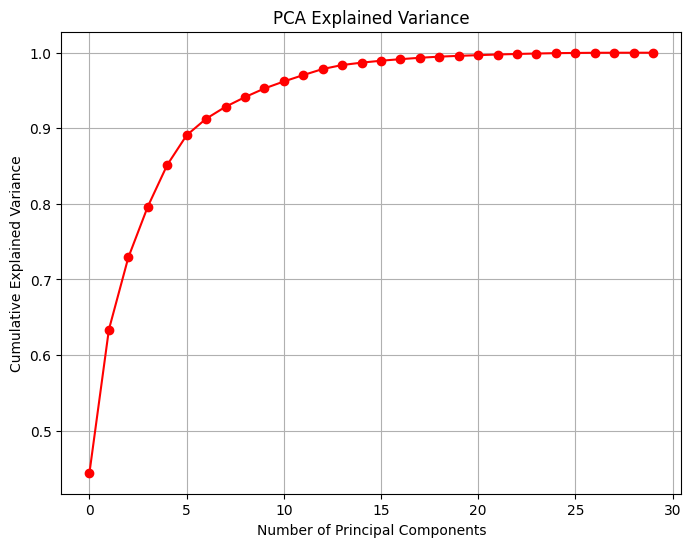

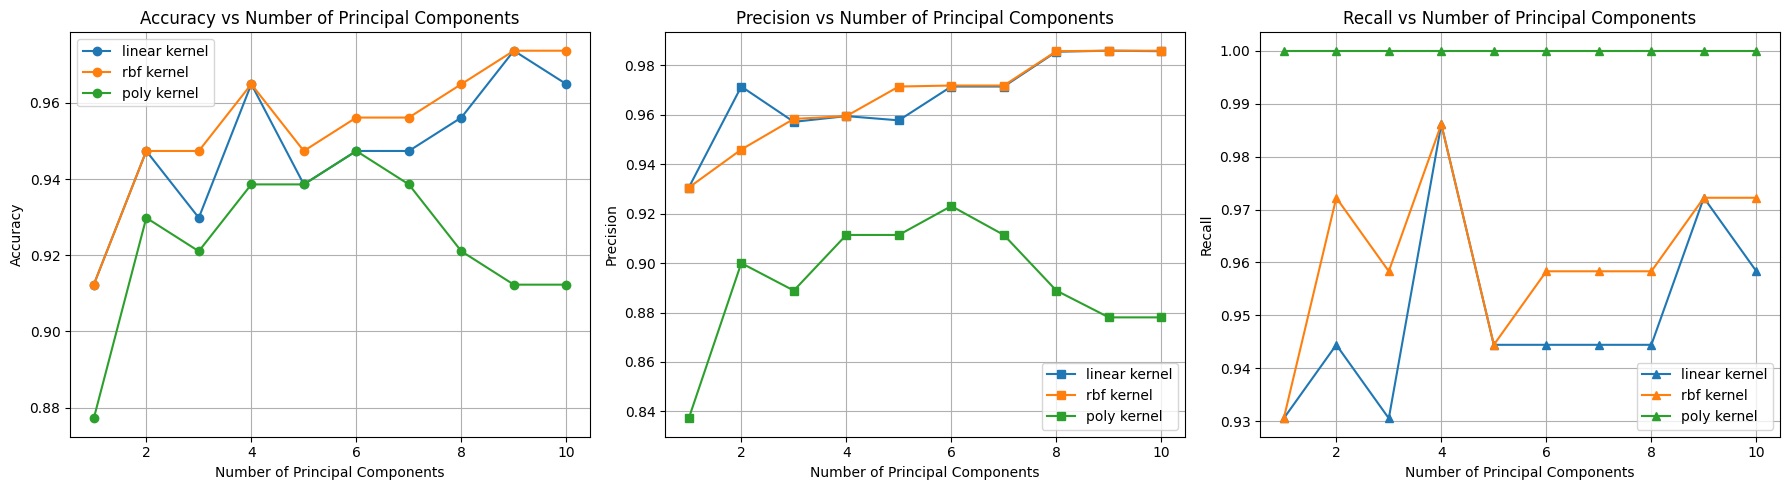

Logistic Regression (HW3) - Accuracy: 0.98, Precision: 0.99, Recall: 0.98


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Load dataset
cancer_data = load_breast_cancer()
df_cancer = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
df_cancer['target'] = cancer_data.target

X = df_cancer.drop('target', axis=1).values
y = df_cancer['target']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Visualize cumulative explained variance to decide on number of components
pca_full = PCA().fit(X_train_scaled)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', color='red')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Lists to store evaluation metrics
max_k = 10 
accuracy_scores = {'linear': [], 'rbf': [], 'poly': []}
precision_scores = {'linear': [], 'rbf': [], 'poly': []}
recall_scores = {'linear': [], 'rbf': [], 'poly': []}

# Loop through different numbers of PCA components
for k in range(1, max_k + 1):
    # Apply PCA
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Experiment with different SVM kernels
    for kernel in ['linear', 'rbf', 'poly']:
        svm = SVC(kernel=kernel, random_state=42)
        
        # Train the SVM classifier
        svm.fit(X_train_pca, y_train)
        
        # Make predictions
        y_pred = svm.predict(X_test_pca)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        
        # Store results
        accuracy_scores[kernel].append(accuracy)
        precision_scores[kernel].append(precision)
        recall_scores[kernel].append(recall)

# Plotting results
k_values = range(1, max_k + 1)

plt.figure(figsize=(18, 5))

# Plot Accuracy
plt.subplot(1, 3, 1)
for kernel in accuracy_scores:
    plt.plot(k_values, accuracy_scores[kernel], marker='o', label=f'{kernel} kernel')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Principal Components')
plt.legend()
plt.grid(True)

# Plot Precision
plt.subplot(1, 3, 2)
for kernel in precision_scores:
    plt.plot(k_values, precision_scores[kernel], marker='s', label=f'{kernel} kernel')
plt.xlabel('Number of Principal Components')
plt.ylabel('Precision')
plt.title('Precision vs Number of Principal Components')
plt.legend()
plt.grid(True)

# Plot Recall
plt.subplot(1, 3, 3)
for kernel in recall_scores:
    plt.plot(k_values, recall_scores[kernel], marker='^', label=f'{kernel} kernel')
plt.xlabel('Number of Principal Components')
plt.ylabel('Recall')
plt.title('Recall vs Number of Principal Components')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# values from Homework 3
logistic_regression_accuracy = 0.9825  
logistic_regression_precision = 0.9859  
logistic_regression_recall = 0.9829  

# Display comparison
print(f"Logistic Regression (HW3) - Accuracy: {logistic_regression_accuracy:.2f}, "
      f"Precision: {logistic_regression_precision:.2f}, Recall: {logistic_regression_recall:.2f}")


Comparing different kernels with grid search optimization:

Training linear kernel...


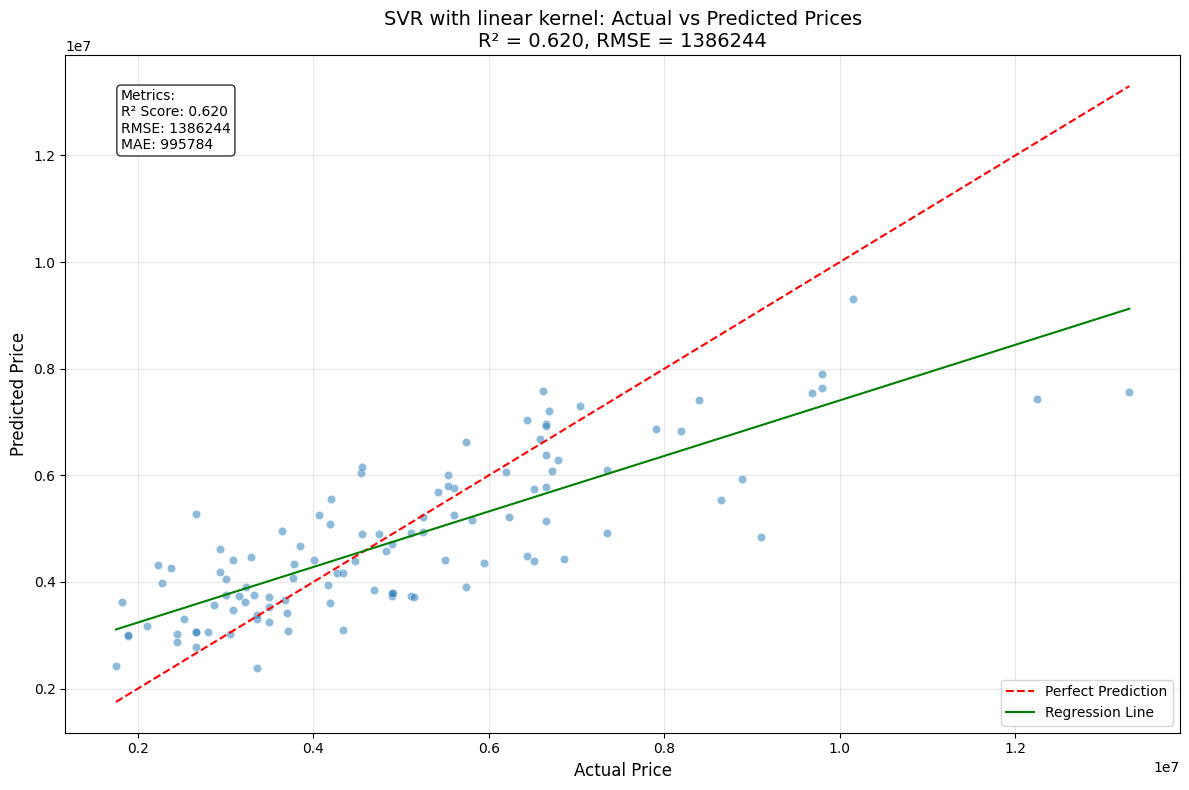


Training rbf kernel...


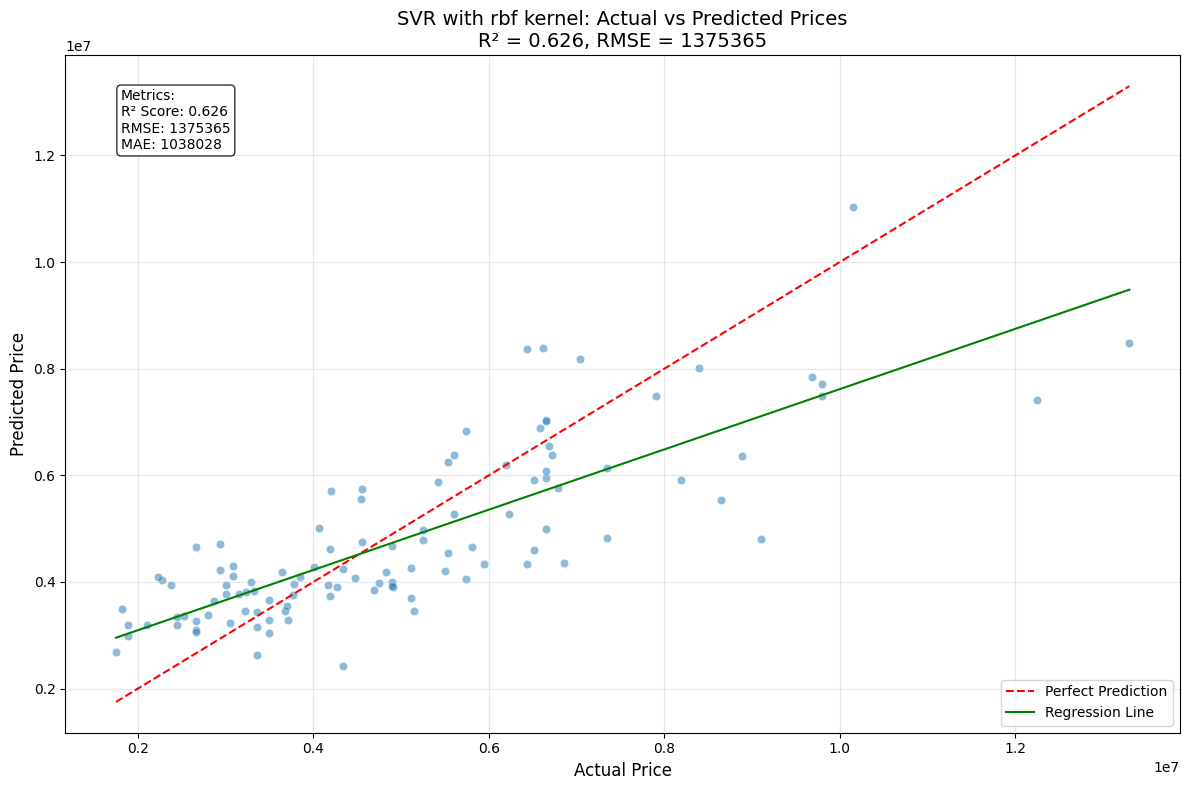


Training poly kernel...


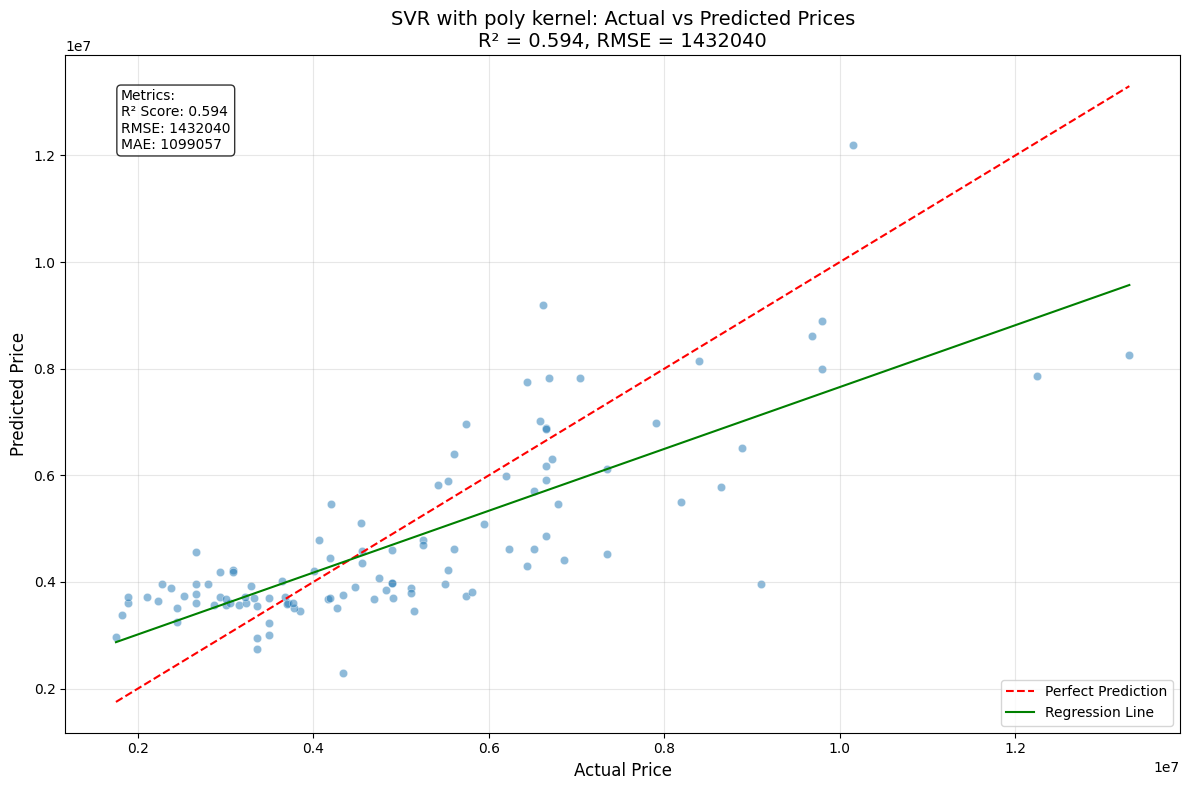


Training sigmoid kernel...


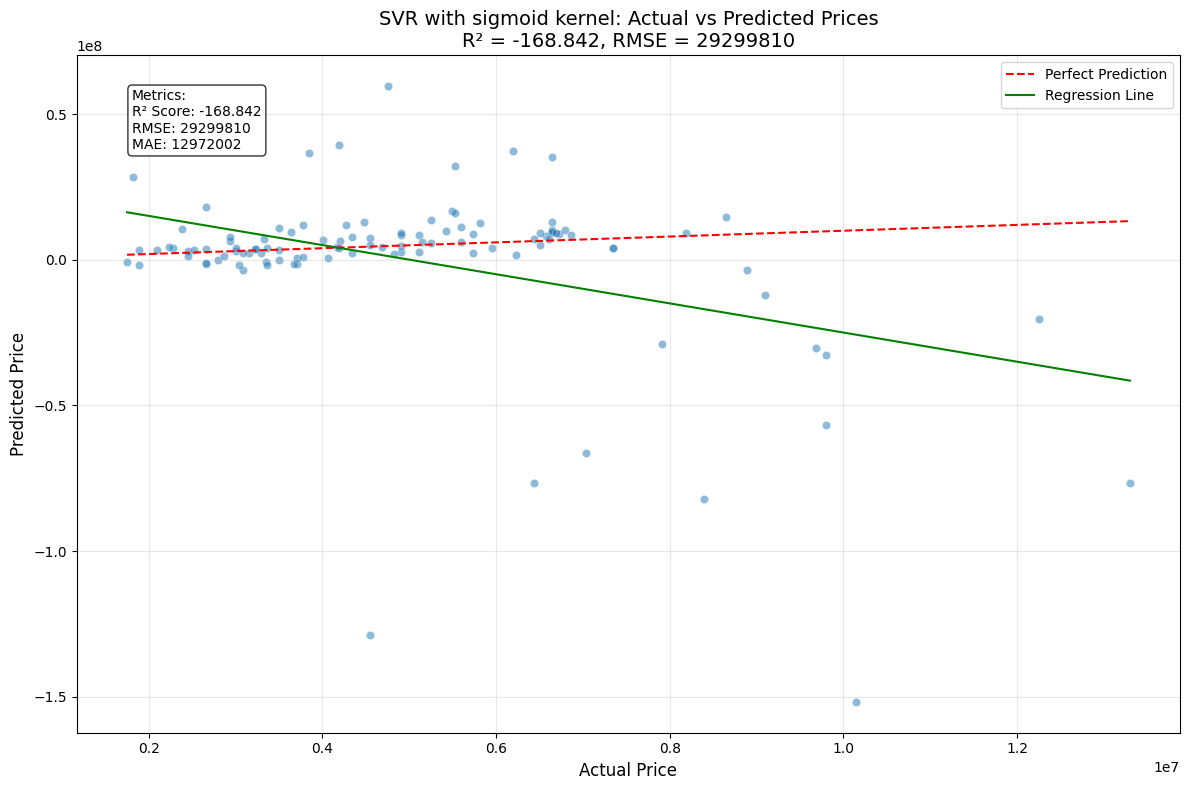


Kernel Comparison Results:
 kernel          mse         rmse          mae       r2                                             best_params
 linear 1.921673e+12  1386244.056   995784.207    0.620                                {'C': 1, 'epsilon': 0.1}
    rbf 1.891630e+12  1375365.384  1038028.145    0.626               {'C': 100, 'epsilon': 0.1, 'gamma': 0.01}
   poly 2.050737e+12  1432039.625  1099056.800    0.594 {'C': 10, 'degree': 2, 'epsilon': 0.1, 'gamma': 'auto'}
sigmoid 8.584789e+14 29299810.323 12972001.896 -168.842             {'C': 10, 'epsilon': 0.01, 'gamma': 'auto'}


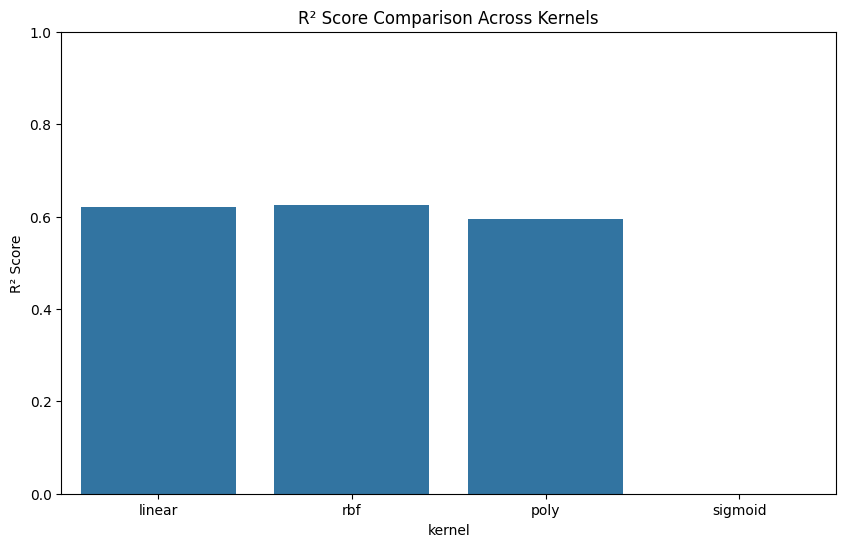

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

def improved_svr_model(X_train, X_test, y_train, y_test, kernel='rbf'):
    """Train SVR with grid search and robust scaling"""
    # Use RobustScaler for better handling of outliers
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    
    # Scale features
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Scale target
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Define parameter grid for each kernel
    param_grids = {
        'rbf': {
            'C': [10, 100, 1000],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'epsilon': [0.1, 0.01, 0.001]
        },
        'linear': {
            'C': [0.1, 1, 10],
            'epsilon': [0.1, 0.01, 0.001]
        },
        'poly': {
            'C': [10, 100],
            'degree': [2, 3],
            'gamma': ['scale', 'auto'],
            'epsilon': [0.1, 0.01]
        },
        'sigmoid': {
            'C': [10, 100],
            'gamma': ['scale', 'auto'],
            'epsilon': [0.1, 0.01]
        }
    }
    
    # Create base SVR model
    svr = SVR(kernel=kernel)
    
    # Perform grid search
    grid_search = GridSearchCV(
        svr,
        param_grids[kernel],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit model
    grid_search.fit(X_train_scaled, y_train_scaled)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Make predictions
    y_pred_scaled = best_model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Plot results with improved visualization
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot
    sns.scatterplot(x=y_test, y=y_pred.ravel(), alpha=0.5)
    
    # Add perfect prediction line
    line_x = np.linspace(y_test.min(), y_test.max(), 100)
    plt.plot(line_x, line_x, 'r--', label='Perfect Prediction')
    
    # Add regression line
    z = np.polyfit(y_test, y_pred.ravel(), 1)
    p = np.poly1d(z)
    plt.plot(line_x, p(line_x), 'g-', label='Regression Line')
    
    plt.xlabel('Actual Price', fontsize=12)
    plt.ylabel('Predicted Price', fontsize=12)
    plt.title(f'SVR with {kernel} kernel: Actual vs Predicted Prices\nR² = {r2:.3f}, RMSE = {rmse:.0f}', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add text box with metrics
    metrics_text = f'Metrics:\nR² Score: {r2:.3f}\nRMSE: {rmse:.0f}\nMAE: {mae:.0f}'
    plt.text(0.05, 0.95, metrics_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'best_params': grid_search.best_params_
    }

def compare_improved_kernels(X_train, X_test, y_train, y_test):
    """Compare different kernels with grid search optimization"""
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']
    results = []
    
    for kernel in kernels:
        print(f"\nTraining {kernel} kernel...")
        metrics = improved_svr_model(X_train, X_test, y_train, y_test, kernel)
        results.append({
            'kernel': kernel,
            'mse': metrics['mse'],
            'rmse': metrics['rmse'],
            'mae': metrics['mae'],
            'r2': metrics['r2'],
            'best_params': metrics['best_params']
        })
    
    # Create results DataFrame with better formatting
    df_results = pd.DataFrame(results)
    df_results = df_results.round(3)
    return df_results

def main_improved(file_path):
    """Main function with improved data preparation and analysis"""
    # Load and prepare data
    try:
        df = pd.read_csv(file_path)
        
        # Convert categorical variables
        categorical_cols = ['mainroad', 'guestroom', 'basement', 
                          'hotwaterheating', 'airconditioning', 'prefarea']
        for col in categorical_cols:
            df[col] = df[col].map({'yes': 1, 'no': 0})
        
        # Separate features and target
        X = df[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
                'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
                'parking', 'prefarea']]
        y = df['price']
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Compare kernels
        print("Comparing different kernels with grid search optimization:")
        results = compare_improved_kernels(X_train, X_test, y_train, y_test)
        
        # Display results in a formatted table
        print("\nKernel Comparison Results:")
        print(results.to_string(index=False))
        
        # Plot comparison of R² scores
        plt.figure(figsize=(10, 6))
        sns.barplot(x='kernel', y='r2', data=results)
        plt.title('R² Score Comparison Across Kernels')
        plt.ylabel('R² Score')
        plt.ylim(0, 1)
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    file_path = 'assets/Housing.csv'
    main_improved(file_path)

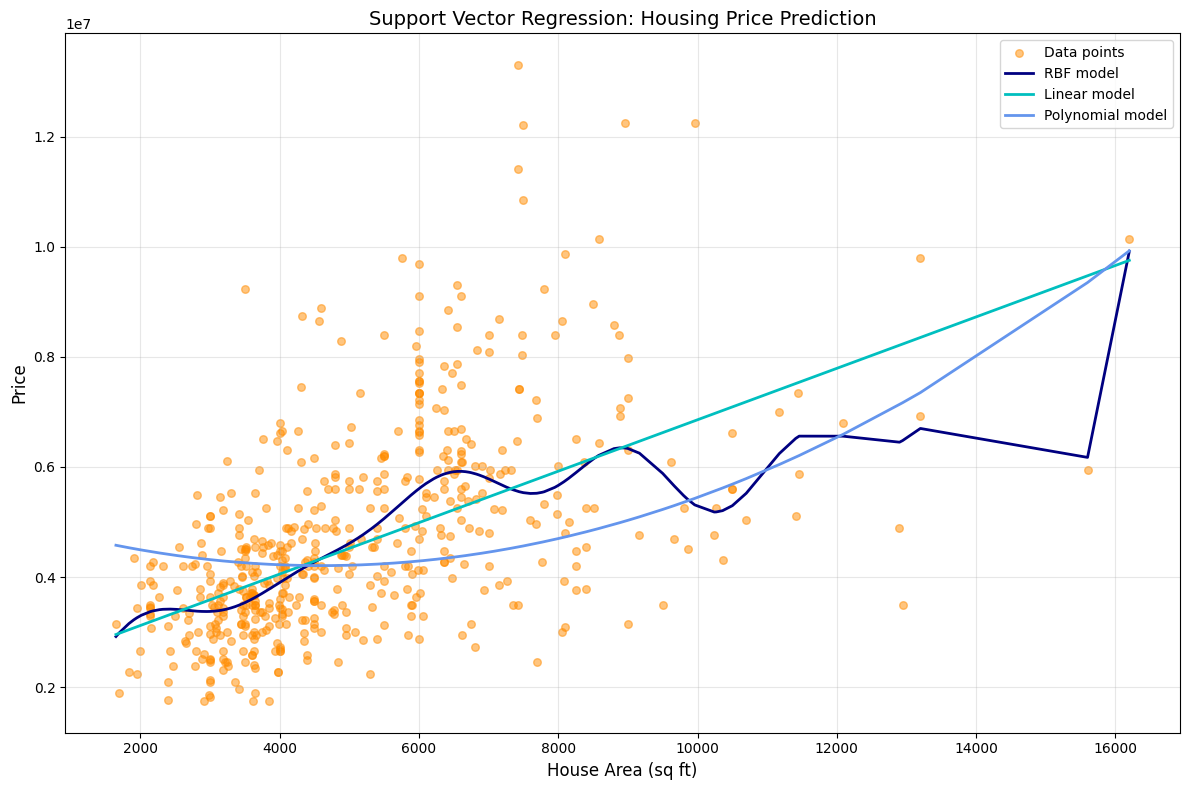

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt

def prepare_data(file_path):
    """Load and prepare the housing dataset"""
    # Load data
    df = pd.read_csv(file_path)
    
    # Convert categorical variables
    categorical_cols = ['mainroad', 'guestroom', 'basement', 
                       'hotwaterheating', 'airconditioning', 'prefarea']
    for col in categorical_cols:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    
    # For visualization, we'll use 'area' as our X feature
    X = df[['area']].values
    y = df['price'].values
    
    return X, y

def plot_svr_comparison(X, y):
    """Create comparison plot of different SVR kernels"""
    # Scale the features
    scaler_X = RobustScaler()
    scaler_y = RobustScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
    
    # Sort X and y for smooth plotting
    sort_idx = np.argsort(X_scaled.ravel())
    X_sorted = X_scaled[sort_idx]
    y_sorted = y_scaled[sort_idx]
    
    # Create and train SVR models
    svr_rbf = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
    svr_lin = SVR(kernel='linear', C=100, epsilon=0.1)
    svr_poly = SVR(kernel='poly', C=100, degree=2, gamma='scale', epsilon=0.1)
    
    # Fit models and make predictions
    y_rbf = svr_rbf.fit(X_sorted, y_sorted).predict(X_sorted)
    y_lin = svr_lin.fit(X_sorted, y_sorted).predict(X_sorted)
    y_poly = svr_poly.fit(X_sorted, y_sorted).predict(X_sorted)
    
    # Convert back to original scale for plotting
    X_plot = scaler_X.inverse_transform(X_sorted)
    y_plot = scaler_y.inverse_transform(y_sorted.reshape(-1, 1))
    y_rbf_plot = scaler_y.inverse_transform(y_rbf.reshape(-1, 1))
    y_lin_plot = scaler_y.inverse_transform(y_lin.reshape(-1, 1))
    y_poly_plot = scaler_y.inverse_transform(y_poly.reshape(-1, 1))
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Plot the actual data points
    plt.scatter(X_plot, y_plot, color='darkorange', label='Data points', 
                alpha=0.5, s=30)
    
    # Plot the predictions
    lw = 2
    plt.plot(X_plot, y_rbf_plot, color='navy', lw=lw, label='RBF model')
    plt.plot(X_plot, y_lin_plot, color='c', lw=lw, label='Linear model')
    plt.plot(X_plot, y_poly_plot, color='cornflowerblue', lw=lw, 
             label='Polynomial model')
    
    # Customize the plot
    plt.xlabel('House Area (sq ft)', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    plt.title('Support Vector Regression: Housing Price Prediction', fontsize=14)
    plt.legend(fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Return models for potential further use
    return svr_rbf, svr_lin, svr_poly

def main():
    """Main function to run the analysis"""
    try:
        # Load and prepare data
        X, y = prepare_data('assets/Housing.csv')
        
        # Create comparison plot
        models = plot_svr_comparison(X, y)
        
    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

Ridge Regression MSE: 967304128476.79
SVR RBF Kernel MSE: 2943512986923.79
SVR Linear Kernel MSE: 1798280910506.73
SVR Polynomial Kernel MSE: 2959410847126.26
Optimal number of PCA components for RBF kernel: 1, MSE: 2844076693503.25


/tmp/ipykernel_15544/4234416372.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  housing_df[binary_columns] = housing_df[binary_columns].replace({'yes': 1, 'no': 0})


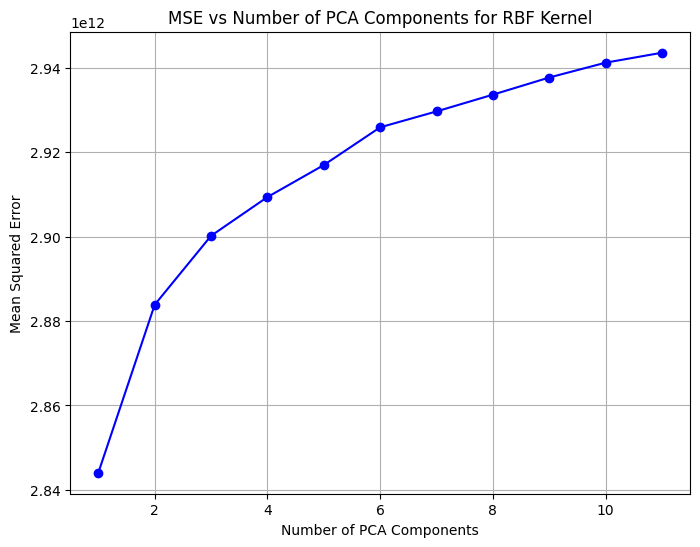

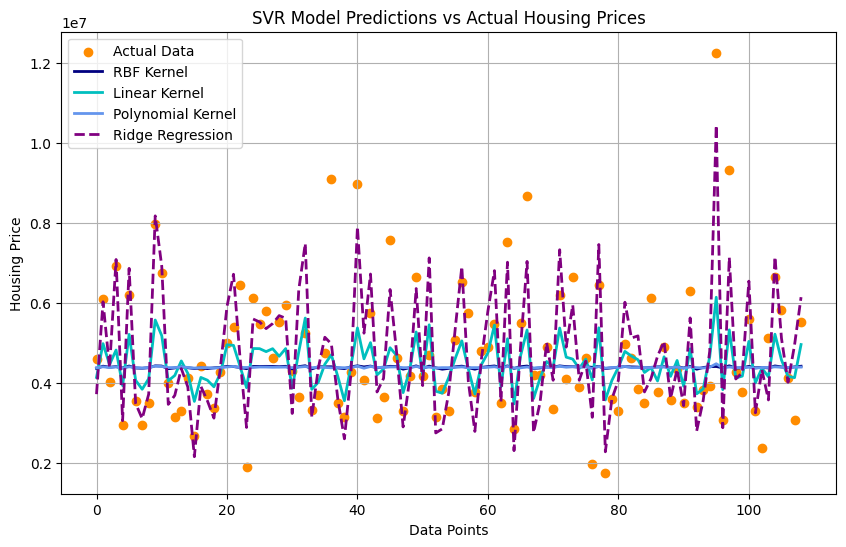

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Load dataset
housing_df = pd.read_csv('assets/Housing.csv')
binary_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
housing_df[binary_columns] = housing_df[binary_columns].replace({'yes': 1, 'no': 0})

# Define input features and target
labels = ["area", "bedrooms", "bathrooms", "stories", "mainroad", 
           "guestroom", "basement", "hotwaterheating", "airconditioning", 
           "parking", "prefarea"]
X = housing_df[labels]
y = housing_df['price']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# #############################################################################
# 1. Fit SVR models with different kernels
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

# Fit models
y_rbf_pred = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin_pred = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly_pred = svr_poly.fit(X_train, y_train).predict(X_test)

# #############################################################################
# 2. Compare with linear regression (Ridge Regression as a regularized model)
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_ridge_pred = ridge_reg.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_ridge_pred)

# Calculate MSE for each SVR model
mse_rbf = mean_squared_error(y_test, y_rbf_pred)
mse_lin = mean_squared_error(y_test, y_lin_pred)
mse_poly = mean_squared_error(y_test, y_poly_pred)

print(f"Ridge Regression MSE: {ridge_mse:.2f}")
print(f"SVR RBF Kernel MSE: {mse_rbf:.2f}")
print(f"SVR Linear Kernel MSE: {mse_lin:.2f}")
print(f"SVR Polynomial Kernel MSE: {mse_poly:.2f}")

# #############################################################################
# 3. Use PCA and identify optimal number of components (K) for highest accuracy
component_range = range(1, 12)
mse_scores = []
optimal_components = 0
best_mse = float("inf")

for k in component_range:
    # Apply PCA
    pca = PCA(n_components=k)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Train and evaluate RBF SVR on reduced data
    svr_rbf_pca = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_rbf_pca.fit(X_train_pca, y_train)
    y_rbf_pca_pred = svr_rbf_pca.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_rbf_pca_pred)
    mse_scores.append(mse)
    
    # Track the best MSE and optimal number of components
    if mse < best_mse:
        best_mse = mse
        optimal_components = k

print(f"Optimal number of PCA components for RBF kernel: {optimal_components}, MSE: {best_mse:.2f}")

# Plot MSE vs Number of Components for RBF Kernel
plt.figure(figsize=(8, 6))
plt.plot(component_range, mse_scores, marker='o', color='blue')
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of PCA Components for RBF Kernel')
plt.grid(True)
plt.show()

# #############################################################################
# 4. Visualization of SVR model predictions
plt.figure(figsize=(10, 6))
lw = 2
plt.scatter(range(len(y_test)), y_test, color='darkorange', label='Actual Data')
plt.plot(range(len(y_test)), y_rbf_pred, color='navy', lw=lw, label='RBF Kernel')
plt.plot(range(len(y_test)), y_lin_pred, color='c', lw=lw, label='Linear Kernel')
plt.plot(range(len(y_test)), y_poly_pred, color='cornflowerblue', lw=lw, label='Polynomial Kernel')
plt.plot(range(len(y_test)), y_ridge_pred, color='purple', lw=lw, linestyle='--', label='Ridge Regression')
plt.xlabel('Data Points')
plt.ylabel('Housing Price')
plt.title('SVR Model Predictions vs Actual Housing Prices')
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_15544/1444923476.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'yes': 1, 'no': 0})


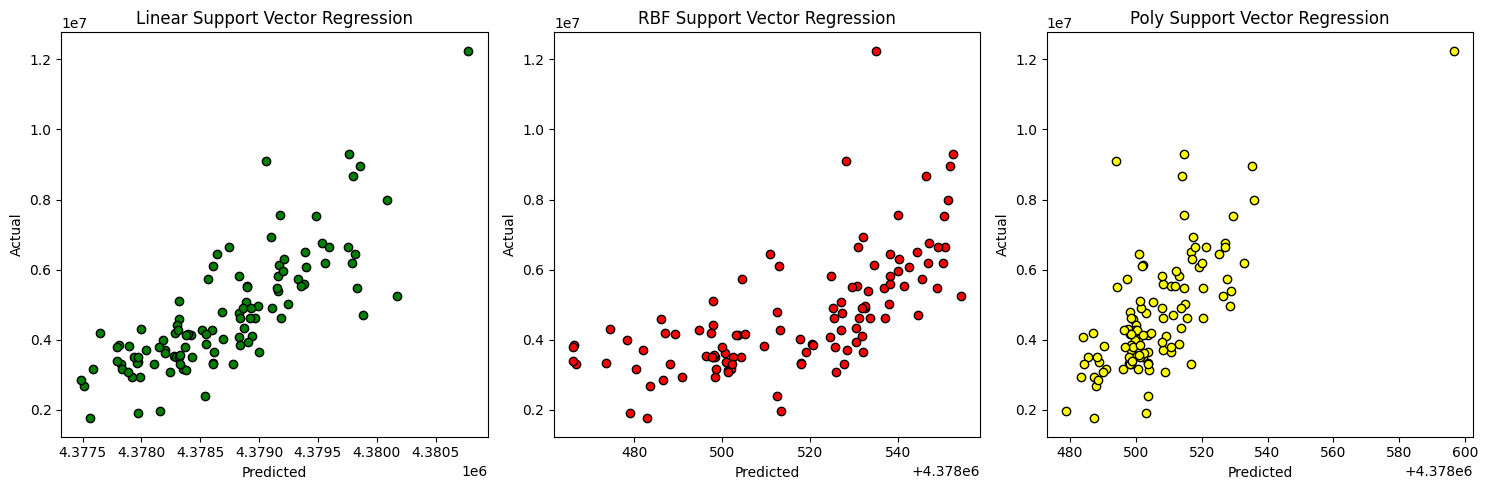

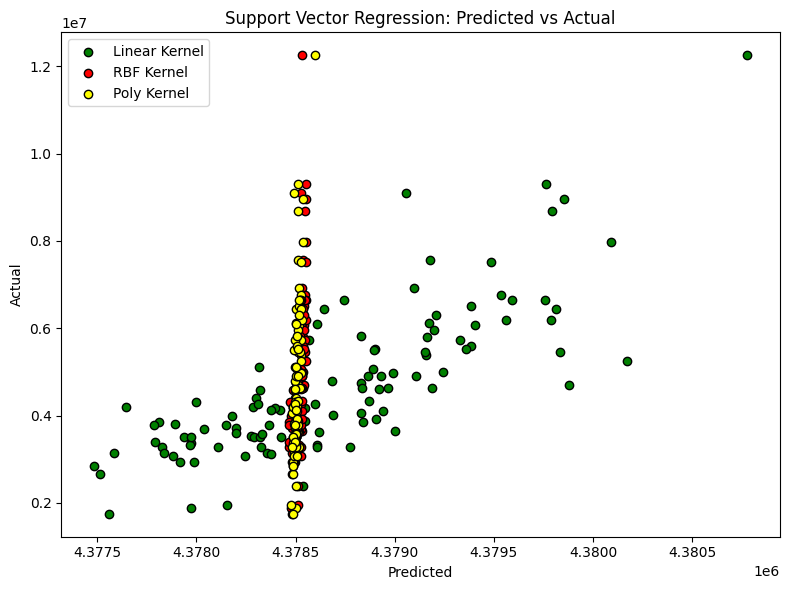

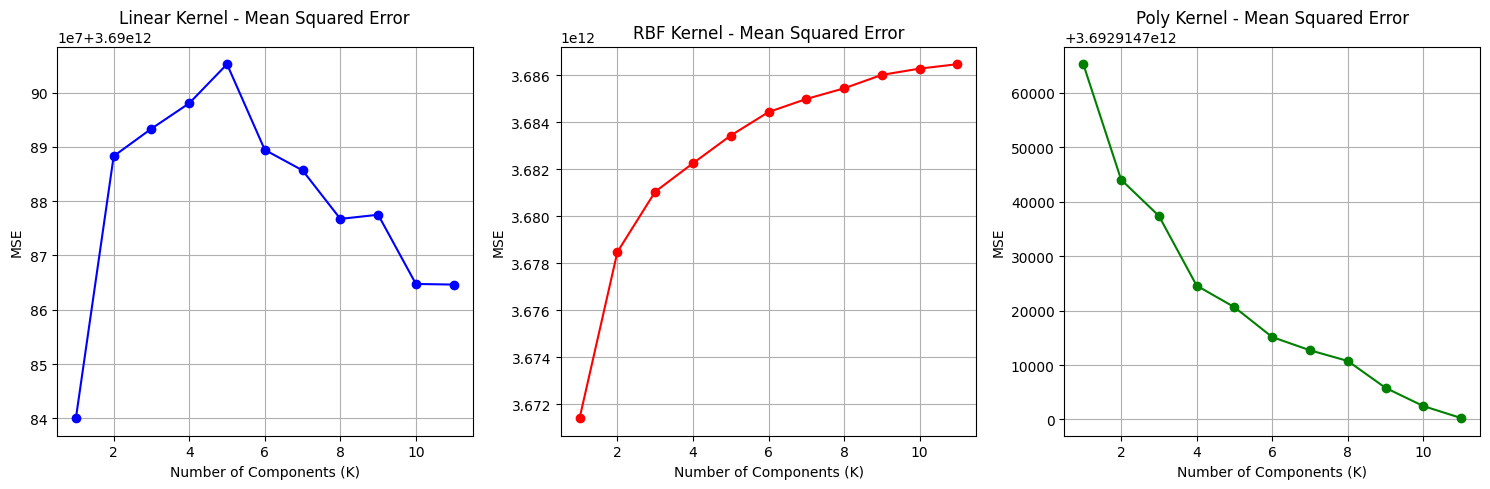

Linear Kernel - Optimal Components: 1, Lowest MSE: 3690840057061.9053
RBF Kernel - Optimal Components: 1, Lowest MSE: 3671413921391.4365
Poly Kernel - Optimal Components: 11, Lowest MSE: 3692914700269.1548


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


def convert_binary_columns(df):
    df = df.copy()  # Create a copy to avoid modifying the original
    df[binary_columns] = (
        df[binary_columns]
        .replace({'yes': 1, 'no': 0})
        .astype('int8')  # Using int8 since we only need 0 and 1
    )
    return df

# Load dataset
housing_df = pd.read_csv('assets/Housing.csv')
housing_df = convert_binary_columns(housing_df)
labels = ["area", "bedrooms", "bathrooms", "stories", "mainroad", 
           "guestroom", "basement", "hotwaterheating", "airconditioning", 
           "parking", "prefarea"]


# Separate features and target variable
X = housing_df[labels]
y = housing_df['price'].values.reshape(-1, 1)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

# Define SVR models
svr_rbf = SVR(kernel='rbf', C=1, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1)
svr_poly = SVR(kernel='poly', C=1, degree=2)

# Train and predict
y_rbf_pred = svr_rbf.fit(X_train, y_train.ravel()).predict(X_test)
y_lin_pred = svr_lin.fit(X_train, y_train.ravel()).predict(X_test)
y_poly_pred = svr_poly.fit(X_train, y_train.ravel()).predict(X_test)

# Plotting predicted vs actual for each kernel
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_lin_pred, y_test, color='green', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear Support Vector Regression')

plt.subplot(1, 3, 2)
plt.scatter(y_rbf_pred, y_test, color='red', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RBF Support Vector Regression')

plt.subplot(1, 3, 3)
plt.scatter(y_poly_pred, y_test, color='yellow', edgecolor='k')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Poly Support Vector Regression')
plt.tight_layout()
plt.show()

# Combined plot
plt.figure(figsize=(8, 6))
plt.scatter(y_lin_pred, y_test, color='green', edgecolor='k', label='Linear Kernel')
plt.scatter(y_rbf_pred, y_test, color='red', edgecolor='k', label='RBF Kernel')
plt.scatter(y_poly_pred, y_test, color='yellow', edgecolor='k', label='Poly Kernel')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Support Vector Regression: Predicted vs Actual')
plt.legend()
plt.tight_layout()
plt.show()

# Function for SVR training with cross-validation and PCA
def svr_train_cv(X, y, kernel_type, component_range, C=1, gamma=0.01, param_grid=None):
    mse_scores = []
    best_mse, optimal_components = float('inf'), None
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for k in component_range:
        # Apply PCA
        pca = PCA(n_components=k)
        X_reduced = pca.fit_transform(X)

        # Grid search for RBF kernel
        if param_grid and kernel_type == 'rbf':
            svr = SVR(kernel=kernel_type)
            grid_search = GridSearchCV(svr, param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_reduced, y.ravel())
            best_params = grid_search.best_params_
            svr_model = SVR(kernel=kernel_type, **best_params)
        else:
            svr_model = SVR(kernel=kernel_type, C=C, gamma=gamma)

        # Cross-validation for each K
        fold_mse = []
        for train_index, test_index in kf.split(X_reduced):
            X_train_cv, X_test_cv = X_reduced[train_index], X_reduced[test_index]
            y_train_cv, y_test_cv = y[train_index], y[test_index]

            svr_model.fit(X_train_cv, y_train_cv.ravel())
            y_pred_cv = svr_model.predict(X_test_cv)
            mse = mean_squared_error(y_test_cv, y_pred_cv)
            fold_mse.append(mse)

        avg_mse = np.mean(fold_mse)
        mse_scores.append(avg_mse)

        if avg_mse < best_mse:
            best_mse = avg_mse
            optimal_components = k

    return mse_scores, best_mse, optimal_components

# Define the component range and parameters for grid search
component_range = list(range(1, 12))
param_grid_svr = {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1], 'epsilon': [0.01, 0.1, 1]}

# Train models with PCA and plot MSE for each kernel
lin_mse_scores, lin_mse, lin_K = svr_train_cv(X_scaled, y, 'linear', component_range)
rbf_mse_scores, rbf_mse, rbf_K = svr_train_cv(X_scaled, y, 'rbf', component_range, param_grid=param_grid_svr)
poly_mse_scores, poly_mse, poly_K = svr_train_cv(X_scaled, y, 'poly', component_range)

# Plot MSE for each kernel
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(component_range, lin_mse_scores, marker='o', color='blue')
plt.title('Linear Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(component_range, rbf_mse_scores, marker='o', color='red')
plt.title('RBF Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(component_range, poly_mse_scores, marker='o', color='green')
plt.title('Poly Kernel - Mean Squared Error')
plt.xlabel('Number of Components (K)')
plt.ylabel('MSE')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print optimal components and lowest MSE for each kernel
print(f'Linear Kernel - Optimal Components: {lin_K}, Lowest MSE: {lin_mse:.4f}')
print(f'RBF Kernel - Optimal Components: {rbf_K}, Lowest MSE: {rbf_mse:.4f}')
print(f'Poly Kernel - Optimal Components: {poly_K}, Lowest MSE: {poly_mse:.4f}')


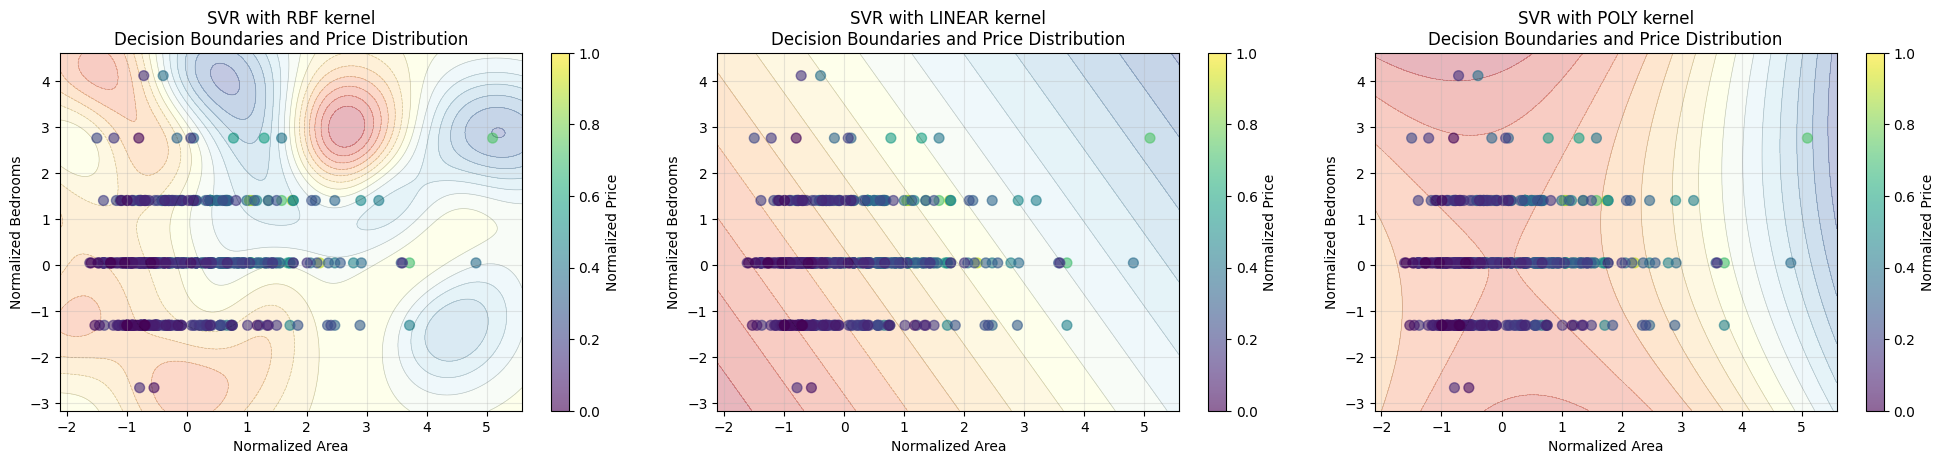

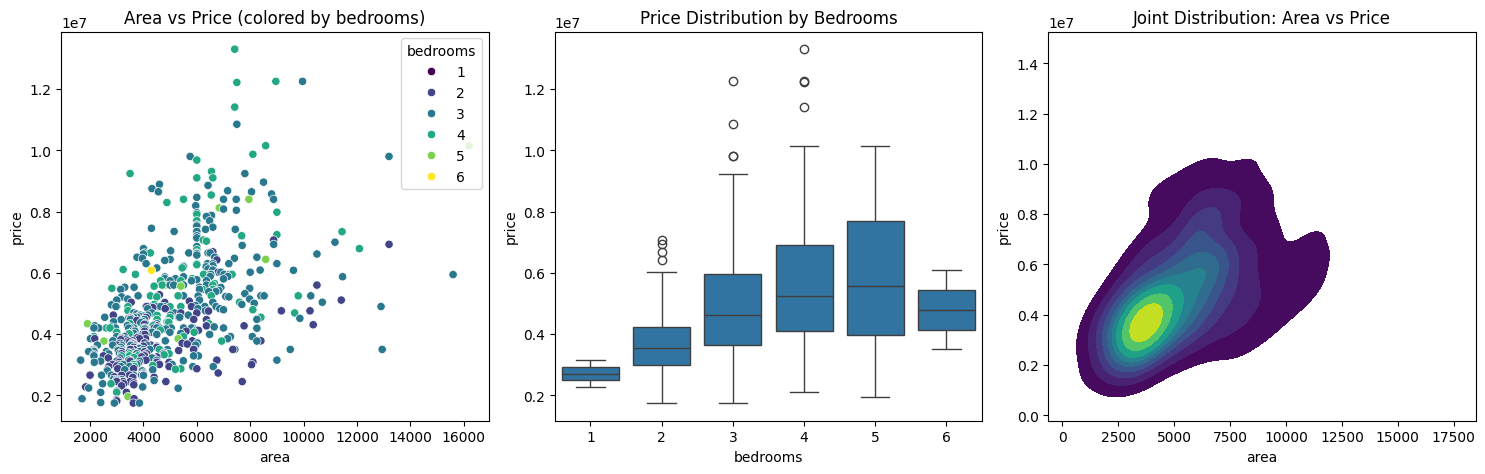

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data_for_visualization(file_path):
    """Load and prepare the housing dataset for enhanced visualization"""
    # Load data
    df = pd.read_csv(file_path)
    
    # Convert categorical variables
    categorical_cols = ['mainroad', 'guestroom', 'basement', 
                       'hotwaterheating', 'airconditioning', 'prefarea']
    for col in categorical_cols:
        df[col] = df[col].map({'yes': 1, 'no': 0})
    
    # Select two most important features for visualization
    X = df[['area', 'bedrooms']].values
    y = df['price'].values
    
    return X, y, df

def plot_svr_with_boundaries(X, y, df):
    """Create enhanced comparison plot with decision boundaries"""
    # Scale the features
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
    
    # Create mesh grid for decision boundary
    x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))
    
    # Create and train SVR models
    kernels = ['rbf', 'linear', 'poly']
    colors = ['navy', 'c', 'cornflowerblue']
    
    plt.figure(figsize=(20, 5))
    
    for idx, (kernel, color) in enumerate(zip(kernels, colors)):
        plt.subplot(1, 3, idx + 1)
        
        # Train SVR model
        if kernel == 'poly':
            svr = SVR(kernel=kernel, C=100, degree=2, gamma='scale', epsilon=0.1)
        else:
            svr = SVR(kernel=kernel, C=100, gamma='scale', epsilon=0.1)
            
        svr.fit(X_scaled, y_scaled)
        
        # Create color map based on predictions
        Z = svr.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        plt.contourf(xx, yy, Z, levels=15, cmap=plt.cm.RdYlBu, alpha=0.3)
        plt.contour(xx, yy, Z, levels=15, colors='k', alpha=0.2, linewidths=0.5)
        
        # Create scatter plot colored by price ranges
        price_normalized = (y - y.min()) / (y.max() - y.min())
        scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], 
                            c=price_normalized, 
                            cmap='viridis',
                            s=50, alpha=0.6,
                            label='Data points')
        
        # Customize the plot
        plt.colorbar(scatter, label='Normalized Price')
        plt.xlabel('Normalized Area')
        plt.ylabel('Normalized Bedrooms')
        plt.title(f'SVR with {kernel.upper()} kernel\nDecision Boundaries and Price Distribution')
        
        # Add grid
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout(pad=2.0)
    plt.show()
    
    # Create additional visualization for price relationships
    plt.figure(figsize=(15, 5))
    
    # Plot area vs price
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df, x='area', y='price', hue='bedrooms', palette='viridis')
    plt.title('Area vs Price (colored by bedrooms)')
    
    # Plot bedrooms vs price
    plt.subplot(1, 3, 2)
    sns.boxplot(data=df, x='bedrooms', y='price')
    plt.title('Price Distribution by Bedrooms')
    
    # Plot joint distribution
    plt.subplot(1, 3, 3)
    sns.kdeplot(data=df, x='area', y='price', cmap='viridis', fill=True)
    plt.title('Joint Distribution: Area vs Price')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function to run the analysis"""
    try:
        # Load and prepare data
        X, y, df = prepare_data_for_visualization('assets/Housing.csv')
        
        # Create comparison plots
        plot_svr_with_boundaries(X, y, df)
        
    except Exception as e:
        print(f"Error: {str(e)}")
        raise e

if __name__ == "__main__":
    main()